In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

100%|██████████| 1.99M/1.99M [00:00<00:00, 104MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


In [ ]:
import os

# List all files and folders in the dataset directory
for root, dirs, files in os.walk(path):
    print("Root:", root)
    print("Directories:", dirs)
    print("Files:", files)
    print()

Root: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2
Directories: []
Files: ['twitter_validation.csv', 'twitter_training.csv']



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [ ]:
train_df = pd.read_csv(os.path.join(path, "twitter_training.csv"))
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
test_df = pd.read_csv(os.path.join(path, "twitter_validation.csv"))
test_df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
# do header
cols = ["tweet_id", "entity", "sentiment", "text"]
train_df.columns = cols
test_df.columns = cols

In [ ]:
train_df.head()

,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
test_df.head()

,tweet_id,entity,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
train_df["sentiment"].value_counts()

,count
sentiment,
Negative,22542
Positive,20831
Neutral,18318
Irrelevant,12990


In [ ]:
label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant": 3}
train_df["sentiment"] = train_df["sentiment"].map(label_mapping)
test_df["sentiment"] = test_df["sentiment"].map(label_mapping)

In [ ]:
test_df.head()

,tweet_id,entity,sentiment,text
0,352,Amazon,1,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,0,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,0,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,1,Now the President is slapping Americans in the...
4,6273,FIFA,0,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
# Check for missing values
print("Missing values in training data:", train_df.isnull().sum())
print("Missing values in test data:", test_df.isnull().sum())

Missing values in training data: tweet_id       0
entity         0
sentiment      0
text         686
dtype: int64
Missing values in test data: tweet_id     0
entity       0
sentiment    0
text         0
dtype: int64


In [ ]:
# Drop missing values
train_df.dropna(inplace=True)

In [ ]:
train_df.head()

,tweet_id,entity,sentiment,text
0,2401,Borderlands,2,I am coming to the borders and I will kill you...
1,2401,Borderlands,2,im getting on borderlands and i will kill you ...
2,2401,Borderlands,2,im coming on borderlands and i will murder you...
3,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,2,im getting into borderlands and i can murder y...


In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [ ]:
# Download necessary NLTK data (if not already installed)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)


    return text


In [ ]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Check the first few rows to ensure it worked
print(train_df[['text', 'cleaned_text']].head())


                                                text  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                                        cleaned_text  
0  i am coming to the borders and i will kill you...  
1  im getting on borderlands and i will kill you all  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands  and i will murder y...  
4  im getting into borderlands and i can murder y...  


In [ ]:
train_df.head()

,tweet_id,entity,sentiment,text,cleaned_text
0,2401,Borderlands,2,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
1,2401,Borderlands,2,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all
2,2401,Borderlands,2,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
3,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,im getting on borderlands and i will murder y...
4,2401,Borderlands,2,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
texts_train = train_df['cleaned_text'].tolist()
labels_train = train_df['sentiment'].tolist()

texts_test = test_df['cleaned_text'].tolist()
labels_test = test_df['sentiment'].tolist()


In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize the training and test texts
train_encodings = tokenizer(texts_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(texts_test, truncation=True, padding=True, max_length=128)

In [ ]:
# Convert labels to TensorFlow tensors
labels_train = tf.convert_to_tensor(labels_train)
labels_test = tf.convert_to_tensor(labels_test)

# Text to tensor

In [ ]:
# Convert tokenized text to tensors
train_input_ids = tf.convert_to_tensor(train_encodings['input_ids'])
train_attention_mask = tf.convert_to_tensor(train_encodings['attention_mask'])

test_input_ids = tf.convert_to_tensor(test_encodings['input_ids'])
test_attention_mask = tf.convert_to_tensor(test_encodings['attention_mask'])

# Create TensorFlow datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_mask
}, labels_train))

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_mask
}, labels_test))

# Batch and shuffle the datasets for training
train_dataset = train_dataset.shuffle(1000).batch(16)
test_dataset = test_dataset.batch(16)


In [ ]:
from transformers import TFBertForSequenceClassification
from transformers import AdamWeightDecay

# Load BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  # Adjust num_labels based on your task

# Compile the model with an Adam optimizer
model.compile(optimizer=AdamWeightDecay(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Show model summary
model.summary()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109485316 (417.65 MB)
Trainable params: 109485316 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model and store the history
history = model.fit(train_dataset, epochs=3, validation_data = test_dataset)

Epoch 1/3
4625/4625 [==============================] - 1867s 399ms/step - loss: 0.8219 - accuracy: 0.6805 - val_loss: 0.7961 - val_accuracy: 0.7217
Epoch 2/3
4625/4625 [==============================] - 1847s 399ms/step - loss: 0.4501 - accuracy: 0.8378 - val_loss: 0.6250 - val_accuracy: 0.8138
Epoch 3/3
4625/4625 [==============================] - 1848s 400ms/step - loss: 0.2425 - accuracy: 0.9135 - val_loss: 0.4591 - val_accuracy: 0.8619


# Plot loss

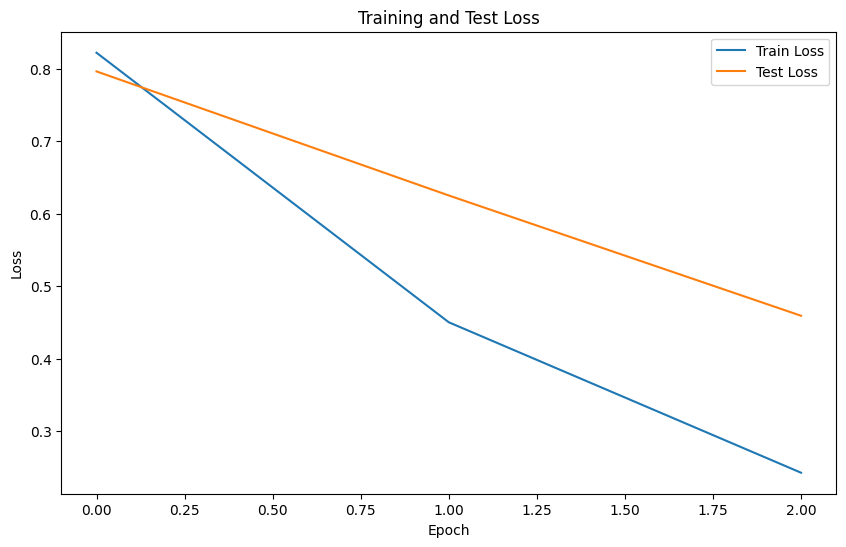

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

63/63 [==============================] - 6s 87ms/step - loss: 0.4591 - accuracy: 0.8619
Test Loss: 0.45906171202659607
Test Accuracy: 0.8618618845939636


### Inference

In [ ]:
new_text = ["I love programming with Python!"]

# Tokenize the new text
new_encodings = tokenizer(new_text, truncation=True, padding=True, max_length=128, return_tensors='tf')

# Predict the label
predictions = model.predict(new_encodings)
predicted_class = tf.argmax(predictions.logits, axis=-1)

print(f"Predicted class: {predicted_class.numpy()}")


1/1 [==============================] - 7s 7s/step
Predicted class: [2]
